In [1]:
import os
import sys
sys.path.append('/home/li.yu/code/JupiterCVML')
sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa')
import ast
import json
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dl.config.label_map_helper import LabelMapHelper
from dl.utils.dust_augmentation.add_dust import AddDust
from dl.utils.dust_augmentation.helper_functions import (
    get_arrays_from_sample,
    get_relative_dust_aug_proba,
    make_sample_from_arrays,
)
from easydict import EasyDict as edict

from utils import normalize_image, plot_image, plot_images

To setup AWS credentials, Please follow instructions at : https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html


In [63]:
def get_sample(root_dir, row):
    data_path = os.path.join(root_dir, row.stereo_pipeline_npz_save_path)
    stereo_data = np.load(data_path)
    img = stereo_data['left']
    img_norm = normalize_image(img, row.hdr_mode)
    depth = stereo_data['point_cloud'][...,2] / 300.0

    label_path = os.path.join(root_dir, row.rectified_label_save_path)
    lbl = np.load(label_path)['left'][:,:,0]
    return img_norm, lbl, depth

In [2]:
_CONFIG_YAML = '/home/li.yu/code/notebooks/configs/train.yml'
with open(_CONFIG_YAML, 'r') as f:
    config = edict(yaml.safe_load(f))

root_dir = config.data.train_set.dataset_path
csv_path = os.path.join(config.data.train_set.dataset_path, config.data.train_set.csv_name)
df = pd.read_csv(csv_path, converters={'label_map': json.loads})
print(df.shape, csv_path)

label_map_helper = LabelMapHelper(
    str(config.inputs.label.label_map_file),
    config.inputs.label.label_map_file_iq,
    reserved_class_name="Humans",
)

dust_augmenter = AddDust(
    df,
    config.augmentation.dust,
    label_map_helper,
    config.data.train_set.dataset_path,
)

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2,3,24,82,93,94,95,96,97,99,100,102,103,104,105,106,107,108,109,110,120,153,157,158,163,174,177,180,181,187,189,199,200,202,203,204,205,225,230,231,232,235,237,239,240,251,252,254,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,275,279,280,281,284,285,286,288) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/li.yu/code/JupiterCVML/europa/base/src/europa/dl/utils/dust_augmentation/helper_functions.py:327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[self.__pod_col_name] = self.df.camera_location.map(
ERROR:

(153501, 325) /data2/jupiter/datasets/halo_rgb_stereo_train_v6_1/master_annotations.csv
{('rear', 'nightime'): 1.0, ('rear', 'dawn_dusk'): 1.0, ('rear', 'daytime'): 1.0}


In [80]:
# %load_ext autoreload
# %autoreload 2

from dl.utils.dust_augmentation.add_dust import AddDust

_CONFIG_YAML = '/home/li.yu/code/notebooks/configs/train.yml'
with open(_CONFIG_YAML, 'r') as f:
    config = edict(yaml.safe_load(f))

dust_augmenter = AddDust(
    df,
    config.augmentation.dust,
    label_map_helper,
    config.data.train_set.dataset_path,
)

ERROR:root:Found values where weights were not given, setting all to missing_keys_p=0.05 !


{('rear', 'nightime'): 1.0, ('rear', 'dawn_dusk'): 1.0, ('rear', 'daytime'): 1.0}


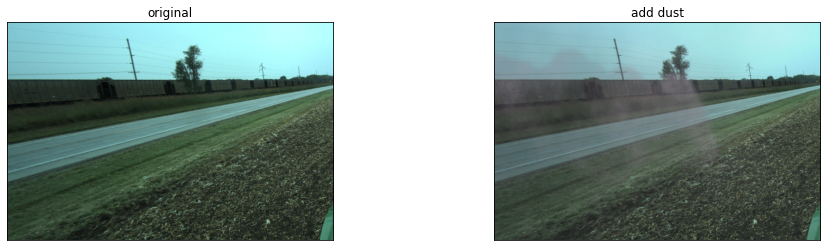

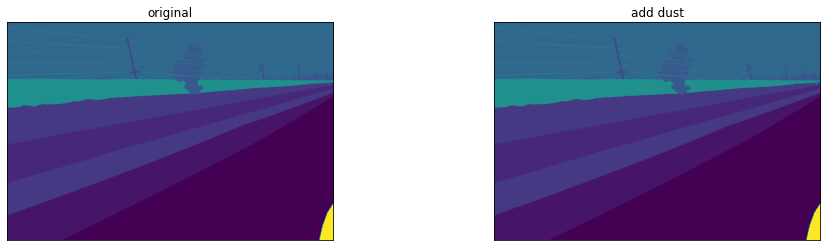

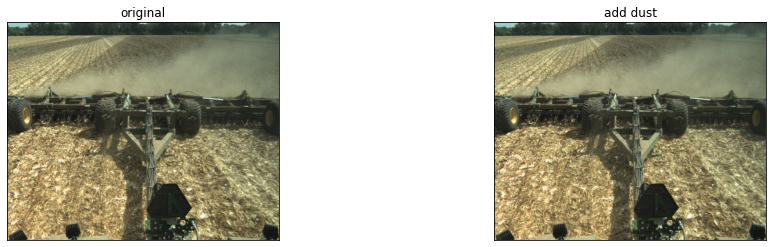

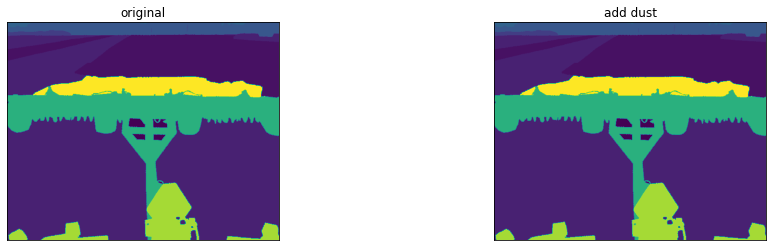

In [82]:
df2 = df
# df2 = df[df.operation_time == 'nightime']
index_list = random.sample(range(len(df2)), 2)
for i in index_list:
    image, label, depth = get_sample(root_dir, df2.iloc[i])
    aug_image, aug_label, aug_depth = dust_augmenter.run_dust_augmentation(df2.iloc[0], image, label, depth, False)
    plot_images([image, aug_image], rows=1, cols=2, titles=['original', 'add dust'])
    plot_images([label, aug_label], rows=1, cols=2, titles=['original', 'add dust'])